### Paul Spendlove
### A02242861

# Historical Analysis of Stock Market Trends

In [33]:
# %pip install mplfinance
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import os
import mplfinance as mpf
from datetime import datetime, timedelta
from mlxtend.frequent_patterns import apriori, association_rules

Create our dataframe for data exploration, exclude data before the year 2000:

In [34]:
df = pd.read_csv('nasdaq_historical_data.csv', index_col='Date', parse_dates=True)
df = df.loc[df.index > '1999-12-31']

names_df = pd.read_csv('ticker_company_name_map.csv', index_col='Ticker')

df_15 = pd.read_csv('nasdaq_high_market_cap_historical_data.csv', index_col='Date', parse_dates=True)
df_15 = df_15.loc[df_15.index > '1999-12-31']

top_tickers = ["AAPL","AMZN","AVGO","BRK/A","BRK/B","GOOG","GOOGL","JPM","LLY","META","MSFT","NVDA","NVO","TSM","V"]

Function to find n number of days of highest difference in market average:

In [35]:
def highest_variance_days(df, num_days):
    daily_pct_change = df.pct_change()
    
    mean_daily_pct_change = daily_pct_change.mean(axis=1)
    
    largest_changes = mean_daily_pct_change.abs().nlargest(num_days)
    
    daily_averages = df.mean(axis=1)
    
    previous_day_averages = daily_averages.shift(1)
    
    for date, pct_change in largest_changes.iteritems():
        current_day_avg = daily_averages.loc[date]
        previous_day_avg = previous_day_averages.loc[date]
        percent_diff = ((current_day_avg - previous_day_avg) / previous_day_avg) * 100
        
        direction = "up" if percent_diff >= 0 else "down"
        sign = "+" if percent_diff >= 0 else "-"
        
        print(f"Date: {date},"
              f"\nToday's Average: {current_day_avg:.2f},"
              f"\nPrevious Day's Average: {previous_day_avg:.2f},"
              f"\nPercent Difference: {sign}{abs(percent_diff):.2f}% ({direction}),"
              f"\nChange: {sign}{pct_change * 100:.2f}% deviation from average.\n\n")


Functions to print the most expensive stock on a given date:

In [36]:
def most_expensive_stock(df, date):
    max_price = df.loc[date].max(skipna=True)
    ticker = df.loc[date].idxmax(skipna=True)
    print(f"The most expensive stock on {date} was {ticker} at a price of ${max_price:.2f}")
    return ticker

Functions to print and plot the top or bottom n stocks on a given date:

In [37]:
def top_growth_stocks(df, start_date, end_date, n):
    df_range = df.loc[start_date:end_date]
    start_prices = df_range.iloc[0]
    end_prices = df_range.iloc[-1]
    percent_changes = ((end_prices - start_prices) / start_prices * 100).sort_values(ascending=False)
    top_n_tickers = percent_changes.head(n).index

    for ticker in top_n_tickers: 
        print(f"{ticker}: {start_prices[ticker]:.2f} -> {end_prices[ticker]:.2f}, {percent_changes[ticker]:.2f}%")
    
    df_range[top_n_tickers].plot(figsize=(12,6))
    plt.title(f"Top {n} Growth Stocks")
    plt.show()
    return top_n_tickers

def bottom_growth_stocks(df, start_date, end_date, n):
    df_range = df.loc[start_date:end_date]
    start_prices = df_range.iloc[0]
    end_prices = df_range.iloc[-1]
    percent_changes = ((end_prices - start_prices) / start_prices * 100).sort_values(ascending=True)
    bottom_n_tickers = percent_changes.head(n).index

    for ticker in bottom_n_tickers: 
        print(f"{ticker}: {start_prices[ticker]:.2f} -> {end_prices[ticker]:.2f}, {percent_changes[ticker]:.2f}%")
    
    df_range[bottom_n_tickers].plot(figsize=(12,6))
    plt.title(f"Bottom {n} Growth Stocks")
    plt.show()
    return bottom_n_tickers

Function to download detailed data on one stock:

In [38]:
def download_stock_history(ticker, subfolder="stock_details"):
    os.makedirs(subfolder, exist_ok=True)

    stock = yf.Ticker(ticker)
    history = stock.history(period="max")

    if not history.empty:
        history.index = history.index.strftime('%Y-%m-%d')

        filename = f"{ticker}.csv"
        filepath = os.path.join(subfolder, filename)
        history.to_csv(filepath)
        print(f"Historical data for {ticker} saved to {filepath}")
    else:
        print(f"Could not download data for {ticker}")

Functions to visualize individual stocks:

In [39]:
def get_stock_data(ticker, subfolder="stock_details"):
   filename = f"{ticker}.csv"
   filepath = os.path.join(subfolder, filename)

   if os.path.exists(filepath):
       df = pd.read_csv(filepath, index_col="Date", parse_dates=True)
   else:
       download_stock_history(ticker, subfolder)  
       df = pd.read_csv(filepath, index_col="Date", parse_dates=True)

   return df

def visualize_candlestick(ticker, start_date, end_date):
    df = get_stock_data(ticker)
    df_filtered = df.loc[start_date:end_date] 

    mpf.plot(df_filtered, type="candle", style="charles",
             title=f"{ticker} Candlestick ({start_date} to {end_date})",
             ylabel="Price")

def visualize_line_volume(ticker, start_date, end_date):
    df = get_stock_data(ticker)
    df_filtered = df.loc[start_date:end_date] 

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

    ax1.plot(df_filtered.index, df_filtered["Close"])
    ax1.set_ylabel("Closing Price")
    ax1.grid(True)

    ax2.bar(df_filtered.index, df_filtered["Volume"])
    ax2.set_ylabel("Volume")
    ax2.grid(True)

    fig.suptitle(f"{ticker} Line Chart with Volume ({start_date} to {end_date})")
    plt.show()

Function to print a list of company names based on ticker:

In [40]:
def display_names(tickers):
    for ticker in tickers:
        if ticker in names_df.index:
            names_filtered = names_df.loc[[ticker]]
            for company_name in names_filtered['Company Name']:
                print(f"{ticker} - {company_name}\n")
        else:
            print(f"No data for ticker: {ticker}")

def display_name(ticker):
    if ticker in names_df.index:
        names_filtered = names_df.loc[[ticker]]
        for company_name in names_filtered['Company Name']:
            print(f"{ticker} - {company_name}\n")
    else:
        print(f"No data for ticker: {ticker}")

def get_short_name(ticker):
    if ticker in names_df.index:
        return names_df.loc[ticker, 'Company Name'].split("-")[0]
    return f"{ticker}"

Function to perform Associate Rule Mining over a range of dates:

In [41]:
def preprocess_data(data, start_date, end_date):
    filtered_data = data.loc[start_date:end_date]
    filtered_data = filtered_data.dropna(axis=1)
    return filtered_data.diff().dropna().applymap(lambda x: True if x > 0 else False)

def perform_rule_mining(data):
    frequent_itemsets = apriori(data, min_support=0.05, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

    top_rules = rules.sort_values(by='confidence', ascending=False).head(15)

    print(top_rules[['antecedents', 'consequents', 'confidence']])

Function to plot percentage change over time of a list of stocks:

In [42]:
def plot_stock_changes(start_date, end_date, tickers):
    filtered_data = df_15.loc[start_date:end_date]

    changes = filtered_data.pct_change().dropna(how='all')

    plt.figure(figsize=(14, 7))
    plt.title(f'Stock Price Percentage Change from {start_date} to {end_date}')
    plt.xlabel('Date')
    plt.ylabel('Percentage Change')

    for ticker in tickers:
        if ticker in filtered_data.columns:
            plt.plot(changes.index, changes[ticker] * 100, label=f'{ticker}')
        else:
            print(f"No data for ticker: {ticker}")

    plt.legend()
    plt.grid(True)
    plt.show()

### Highest Days of Market Variance

These 5 days are sorted by percentage variance (up or down) of the entire market's avarage value.

In [43]:
highest_variance_days(df, 5)

Date: 2015-09-17 00:00:00,
Today's Average: 65502587.98,
Previous Day's Average: 64038016.74,
Percent Difference: +2.29% (up),
Change: +115.92% deviation from average.


Date: 2015-12-15 00:00:00,
Today's Average: 21764025.01,
Previous Day's Average: 27161469.29,
Percent Difference: -19.87% (down),
Change: -72.79% deviation from average.


Date: 2020-11-11 00:00:00,
Today's Average: 127.44,
Previous Day's Average: 126.13,
Percent Difference: +1.04% (up),
Change: +55.64% deviation from average.


Date: 2012-11-30 00:00:00,
Today's Average: 607048258.76,
Previous Day's Average: 568360528.53,
Percent Difference: +6.81% (up),
Change: +32.20% deviation from average.


Date: 2015-03-27 00:00:00,
Today's Average: 65253009.29,
Previous Day's Average: 68991415.19,
Percent Difference: -5.42% (down),
Change: -28.07% deviation from average.




#### So... what?

Clearly something is off.  None of these days coincide with any major events that I would've expected, not to mention how weird those averaged number are.  It turns out, there's a good reason why.

These results are based on the pure average stock price of the market.  In reality, market averages are not calculated this way at all.  It's done by weighting certain companies, so that changes in their stock are shown to affect the market average more than they might in a pure average calculation.  I still can't completely explain why the average is so high in 2015, and so low in 2020, and as far as I can see the historical data is correct.  I'm certainly not going to manually compute the average of 11,000 stock prices, so we'll just have to move on.

Now, I don't have the time or willpower to recreate weighted market average calculation methods with this data.  Fortunately, there is a simple list of the highest days of variance in the actual market averages, so I will proceed by analyzing those.  Don't worry, this dataset will still be useful in analyzing individual stocks.  It just doesn't hold up to the complex process of finding market closing averages.

Based on this article: https://en.wikipedia.org/wiki/List_of_largest_daily_changes_in_the_Nasdaq_Composite
These are the actual 5 days in the 2000's when the market average changed the most.

1. 2001-01-03  +14.17%
2. 2020-03-16  -12.32%
3. 2008-10-13  +11.81%
4. 2000-12-05  +10.48%
5. 2000-04-14  -9.67%

Those percentages are a lot more reasonable.  Now, let's see if any particular events coincide with those days.

1. 2001-01-03

Financially speaking, the chairman of the Federal Reserve announced an interest rate cut, likely causing the increase.  Other than that, there wasn't much news.  "Can we fix it?" from Bob the Builder was at the top of the British music charts, but I doubt that affected the stock market much.

2. 2020-03-16

This one immediately adds up.  At this point, countries, businesses, and society in general were shutting down to prevent the spread of COVID-19.  The financial news of the time even lists the pandemic as the direct cause of this sudden drop.

3. 2008-10-13

The stock market makes up the immediate headlines for this date.  Supposedly, this was in response to actions taken to stop the economic crisis of that year.  As for other news, there was a large wildfire in California, and the economist Paul Krugman won a Nobel Prize that day for "analysis of trade patterns and location of economic activity", a feat that impresses me more and more as I work on this project.

4. 2000-12-05

There wasn't much to find for this day either.  Blackberry devices were growing in popularity and stock value, and the U.S. Nuclear Regulatory Commission filed an event report on the handling of an exposed Cesium-137 sample.

5. 2000-04-14

This date had a lot of finacial news, revolving around struggling brokerage firms and the collapse of stocks previously considered safe.  This probably contributed to the sudden dip in average value, but there's no sign of news outside of the stock market that would've had any impact.

On the surface, only one of these 5 days seems to be directly related to non-finacial news.  With some extrapolation, that ratio applies to my faulty results as well.  Let's look a bit further into some key stocks for each of those days.

### 1. 2001-01-03

CXW: 1.25 -> 2.50, 100.00%
MPAA: 0.69 -> 1.30, 88.64%
CDMO: 41.56 -> 76.56, 84.21%
WAVD: 0.94 -> 1.72, 83.33%
EGHT: 1.75 -> 3.06, 75.00%
ASXC: 178.75 -> 300.62, 68.18%
INSM: 37.50 -> 61.25, 63.33%
GNSS: 2.38 -> 3.88, 63.16%
BKTI: 2.81 -> 4.53, 61.11%
FLL: 0.47 -> 0.72, 53.33%


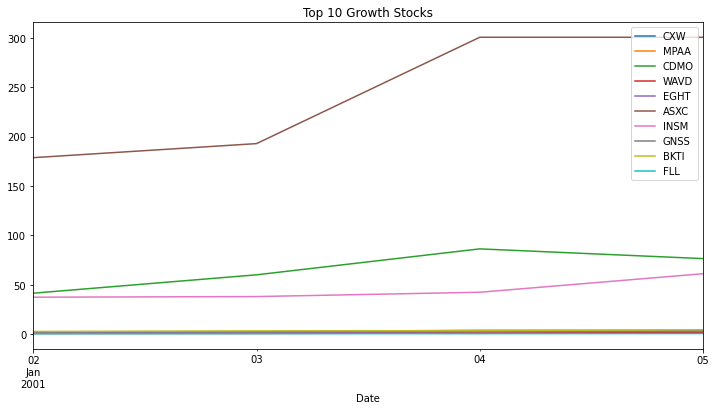

CXW - CoreCivic, Inc. Common Stock

MPAA - Motorcar Parts of America, Inc. - Common Stock

CDMO - Avid Bioservices, Inc. - Common Stock

WAVD - WaveDancer, Inc.  - Common Stock

EGHT - 8x8 Inc - Common stock

ASXC - Asensus Surgical, Inc. Common Stock

INSM - Insmed Incorporated - Common Stock

GNSS - Genasys Inc. - Common Stock

BKTI - BK Technologies Corporation Common Stock

FLL - Full House Resorts, Inc. - Common Stock



In [44]:
display_names(top_growth_stocks(df, '2001-01-01', '2001-01-07', 10))

LSTA: 65625.00 -> 42187.50, -35.71%
PCG: 19.56 -> 12.62, -35.46%
ITI: 7.25 -> 4.81, -33.62%
SAVA: 104.12 -> 69.12, -33.61%
EIX: 15.00 -> 10.31, -31.25%
INUV: 3.59 -> 2.50, -30.43%
ISSC: 11.08 -> 8.12, -26.69%
MEI: 8.21 -> 6.06, -26.26%
FCEL: 4522.50 -> 3384.00, -25.17%
IDR: 1.12 -> 0.84, -25.00%


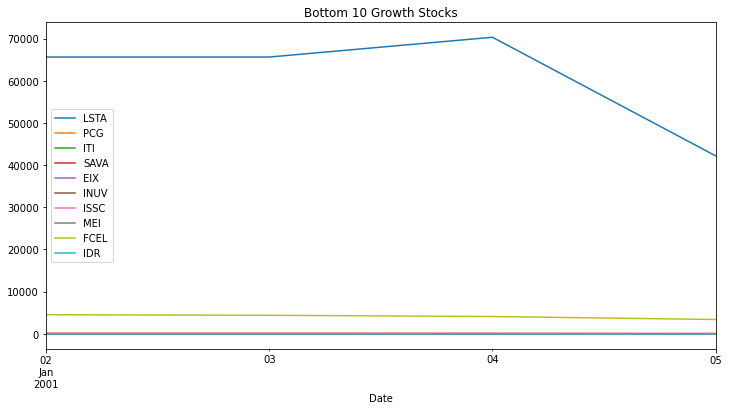

LSTA - Lisata Therapeutics, Inc. - Common Stock

PCG - Pacific Gas & Electric Co. Common Stock

ITI - Iteris, Inc. - Common Stock

SAVA - Cassava Sciences, Inc. - Common Stock

EIX - Edison International Common Stock

INUV - Inuvo, Inc.

ISSC - Innovative Solutions and Support, Inc. - Common Stock

MEI - Methode Electronics, Inc. Common Stock

FCEL - FuelCell Energy, Inc. - Common Stock

IDR - Idaho Strategic Resources, Inc. Common Stock



In [45]:
display_names(bottom_growth_stocks(df, '2001-01-01', '2001-01-07', 10))

### 2. 2020-03-16

LUMO: 0.93 -> 7.12, 665.59%
BMRA: 2.42 -> 7.15, 195.45%
NBY: 10.15 -> 29.40, 189.66%
APCX: 0.20 -> 0.55, 169.61%
AHT: 65.00 -> 139.00, 113.85%
PGEN: 1.55 -> 2.95, 90.32%
TNXP: 106.00 -> 194.00, 83.02%
LFMD: 0.70 -> 1.25, 78.57%
MRNS: 4.76 -> 8.40, 76.47%
ARQT: 18.98 -> 33.32, 75.55%


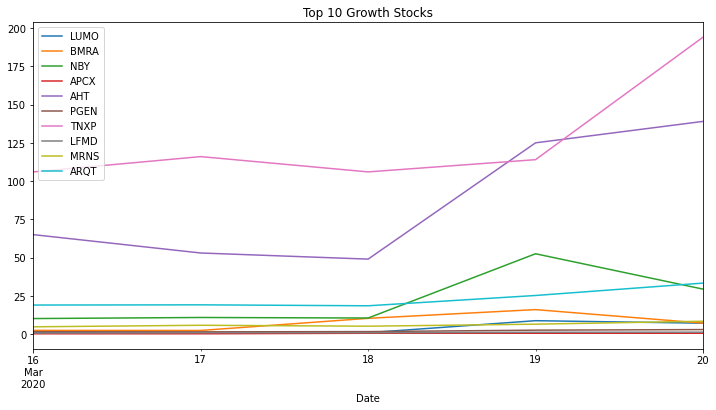

LUMO - Lumos Pharma, Inc. - Common Stock

BMRA - Biomerica, Inc. - Common Stock

NBY - NovaBay Pharmaceuticals, Inc. Common Stock

APCX - AppTech Payments Corp. - Common stock

AHT - Ashford Hospitality Trust Inc Common Stock

PGEN - Precigen, Inc. - Common Stock

TNXP - Tonix Pharmaceuticals Holding Corp. - Common Stock

LFMD - LifeMD, Inc. - Common Stock

MRNS - Marinus Pharmaceuticals, Inc. - Common Stock

ARQT - Arcutis Biotherapeutics, Inc. - Common stock



In [46]:
display_names(top_growth_stocks(df, '2020-03-14', '2020-03-20', 10))

Notice something interesting here: The top stocks are almost all pharmaceutical related.  I'd say that's pretty obviously related to current events of the time.

INLX: 5.00 -> 0.08, -98.40%
SLNG: 2.50 -> 0.92, -63.20%
SRG: 16.20 -> 6.49, -59.94%
TACT: 6.83 -> 3.14, -54.03%
FNGR: 0.60 -> 0.28, -53.33%
MHLD: 0.82 -> 0.40, -51.22%
NTG: 23.00 -> 11.40, -50.43%
GPMT: 8.59 -> 4.26, -50.41%
ACR: 19.89 -> 9.99, -49.77%
SABR: 6.44 -> 3.31, -48.60%


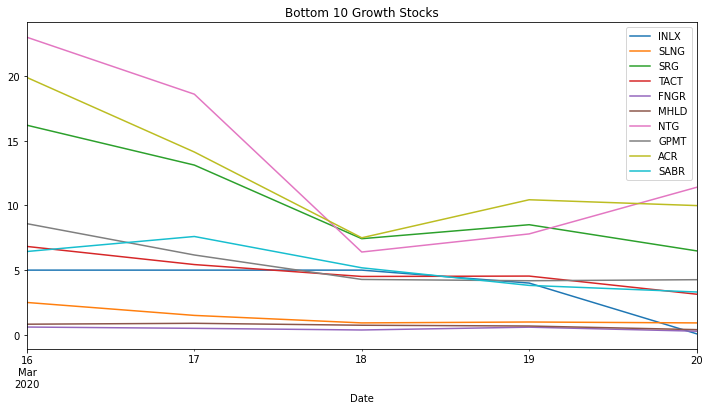

INLX - Intellinetics, Inc. Common Stock

SLNG - Stabilis Solutions, Inc. - Common Stock

SRG - Seritage Growth Properties Class A Common Stock

TACT - TransAct Technologies Incorporated - Common Stock

FNGR - FingerMotion, Inc. - common stock

MHLD - Maiden Holdings, Ltd. - Common Stock

NTG - Tortoise Midstream Energy Fund, Inc. Common Stock

GPMT - Granite Point Mortgage Trust Inc. Common Stock

ACR - ACRES Commercial Realty Corp. Common Stock

SABR - Sabre Corporation - Common Stock



In [47]:
display_names(bottom_growth_stocks(df, '2020-03-14', '2020-03-20', 10))

### 3. 2008-10-13

PALT: 2.33 -> 5.95, 155.00%
CTSO: 1.00 -> 2.50, 150.00%
CYTH: 3.00 -> 6.00, 100.00%
EP: 1.01 -> 1.92, 90.48%
UAL: 7.00 -> 12.28, 75.43%
APTO: 10.80 -> 18.00, 66.67%
VCEL: 30.40 -> 46.40, 52.63%
BWEN: 70.50 -> 107.00, 51.77%
TOMZ: 25.60 -> 37.92, 48.12%
UAVS: 20625.00 -> 30000.00, 45.45%


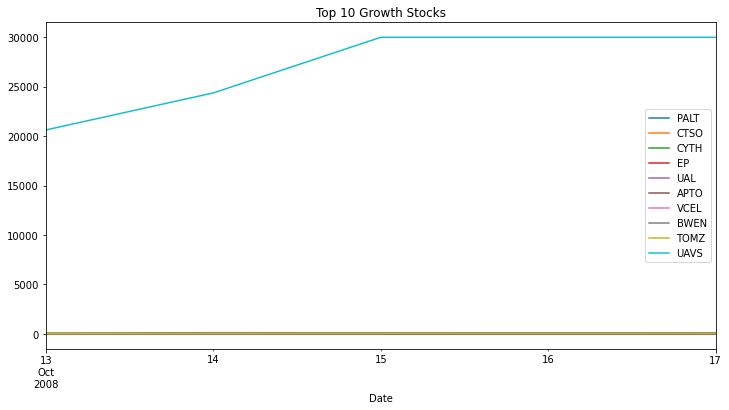

PALT - Paltalk, Inc. - Common Stock

CTSO - Cytosorbents Corporation - Common Stock

CYTH - Cyclo Therapeutics, Inc. - Common Stock

EP - Empire Petroleum Corporation Common Stock

UAL - United Airlines Holdings, Inc. - Common Stock

APTO - Aptose Biosciences, Inc. - Common Shares

VCEL - Vericel Corporation - Common Stock

BWEN - Broadwind, Inc. - Common Stock

TOMZ - TOMI Environmental Solutions, Inc. - Common Stock

UAVS - AgEagle Aerial Systems, Inc. Common Stock



In [48]:
display_names(top_growth_stocks(df, '2008-10-12', '2008-10-17', 10))

NEPH: 81.00 -> 30.60, -62.22%
FLUT: 33.10 -> 14.20, -57.10%
HGBL: 0.69 -> 0.30, -56.52%
FTFT: 21.60 -> 9.60, -55.56%
PLAB: 1.65 -> 0.77, -53.33%
CDXC: 3.15 -> 1.53, -51.43%
PMN: 27.60 -> 14.40, -47.83%
MRKR: 10800.00 -> 6000.00, -44.44%
PRTG: 7.00 -> 4.00, -42.86%
UONEK: 0.36 -> 0.21, -41.67%


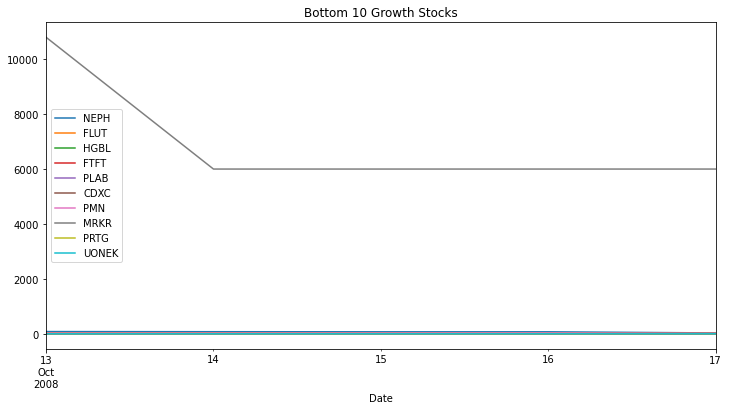

NEPH - Nephros, Inc. - Common Stock

FLUT - Flutter Entertainment plc Ordinary Shares

HGBL - Heritage Global Inc. - Common Stock

FTFT - Future FinTech Group Inc. - Common Stock

PLAB - Photronics, Inc. - Common Stock

CDXC - ChromaDex Corporation - Common Stock

PMN - ProMIS Neurosciences Inc. - Common Shares

MRKR - Marker Therapeutics, Inc. - Common Stock

PRTG - Portage Biotech Inc. - Common Stock

UONEK - Urban One, Inc.  - Class D Common Stock



In [49]:
display_names(bottom_growth_stocks(df, '2008-10-12', '2008-10-17', 10))

### 4. 2000-12-05

EGY: 0.25 -> 0.47, 87.20%
ASYS: 5.69 -> 9.53, 67.58%
BRKR: 17.12 -> 28.69, 67.52%
WYY: 1.88 -> 3.12, 66.67%
NTAP: 57.88 -> 87.19, 50.65%
DWSN: 1.02 -> 1.52, 50.00%
NVEC: 6.25 -> 9.38, 50.00%
EGHT: 2.12 -> 3.19, 50.00%
KOPN: 10.31 -> 15.44, 49.70%
EMKR: 1267.50 -> 1850.00, 45.96%


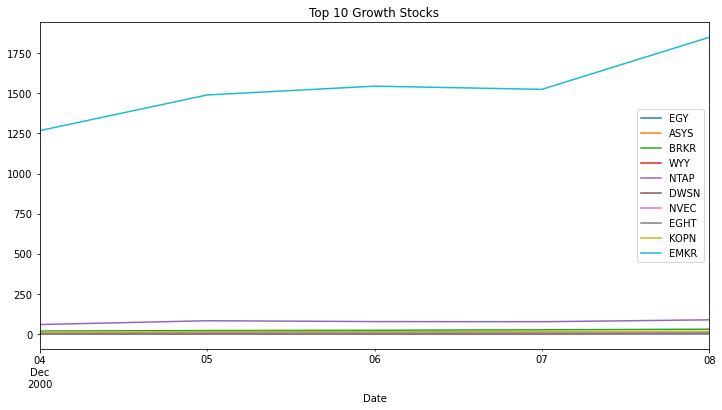

EGY - VAALCO Energy, Inc.  Common Stock

ASYS - Amtech Systems, Inc. - Common Stock

BRKR - Bruker Corporation - Common Stock

WYY - WidePoint Corporation Common Stock

NTAP - NetApp, Inc. - Common Stock

DWSN - Dawson Geophysical Company - Common Stock

NVEC - NVE Corporation - Common Stock

EGHT - 8x8 Inc - Common stock

KOPN - Kopin Corporation - Common Stock

EMKR - EMCORE Corporation - Common Stock



In [50]:
display_names(top_growth_stocks(df, '2000-12-03', '2000-12-09', 10))

CNXN: 21.19 -> 9.81, -53.69%
PPBI: 2.97 -> 1.41, -52.63%
VTNR: 18.00 -> 12.00, -33.33%
CMCL: 2.34 -> 1.56, -33.33%
CAMP: 346.44 -> 231.44, -33.20%
NSIT: 21.00 -> 15.06, -28.27%
CCK: 4.31 -> 3.12, -27.54%
PWFL: 2.88 -> 2.12, -26.09%
DAR: 0.50 -> 0.38, -25.00%
ENSV: 15.00 -> 11.25, -25.00%


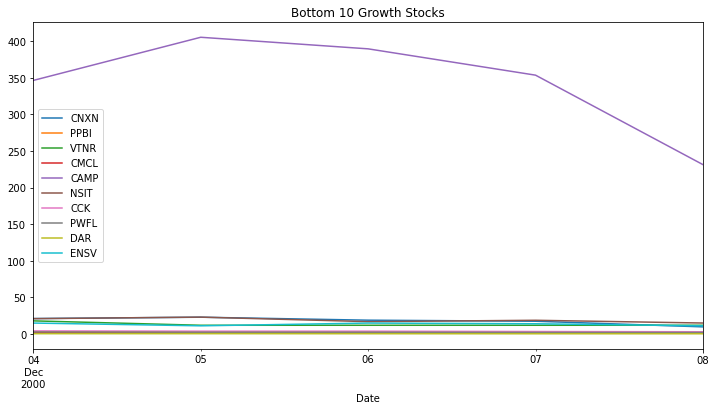

CNXN - PC Connection, Inc. - Common Stock

PPBI - Pacific Premier Bancorp Inc - Common Stock

VTNR - Vertex Energy, Inc - Common Stock

CMCL - Caledonia Mining Corporation Plc Common Shares

CAMP - CalAmp Corp. - Common Stock

NSIT - Insight Enterprises, Inc. - Common Stock

CCK - Crown Holdings, Inc.

PWFL - PowerFleet, Inc. - Common Stock

DAR - Darling Ingredients Inc. Common Stock

ENSV - Enservco Corporation Common Stock



In [51]:
display_names(bottom_growth_stocks(df, '2000-12-03', '2000-12-09', 10))

### 5. 2000-04-14

SIGA: 3.00 -> 4.50, 50.00%
PLX: 25.00 -> 37.50, 50.00%
CAMP: 402.50 -> 573.56, 42.50%
SMSI: 284.00 -> 380.00, 33.80%
COHR: 3.73 -> 4.98, 33.47%
DGX: 10.53 -> 14.00, 32.94%
REGN: 19.25 -> 24.88, 29.22%
VERU: 0.75 -> 0.97, 29.17%
PLAB: 24.62 -> 31.62, 28.43%
SGRP: 2.25 -> 2.88, 27.78%


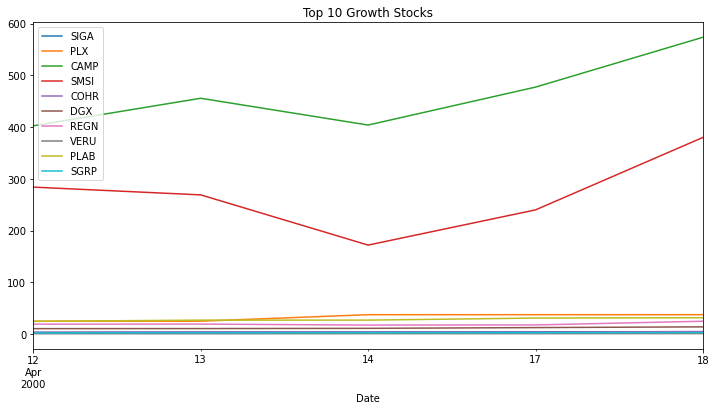

SIGA - SIGA Technologies Inc. - Common Stock

PLX - Protalix BioTherapeutics, Inc. (DE) Common Stock

CAMP - CalAmp Corp. - Common Stock

SMSI - Smith Micro Software, Inc. - Common Stock

COHR - Coherent Corp. Common Stock

DGX - Quest Diagnostics Incorporated Common Stock

REGN - Regeneron Pharmaceuticals, Inc. - Common Stock

VERU - Veru Inc. - Common Stock

PLAB - Photronics, Inc. - Common Stock

SGRP - SPAR Group, Inc. - Common Stock



In [52]:
display_names(top_growth_stocks(df, '2000-04-12', '2000-04-18', 10))

PETS: 2.50 -> 1.25, -50.00%
ERNA: 7250.00 -> 4000.00, -44.83%
POCI: 5765.62 -> 3234.38, -43.90%
DX: 12.00 -> 6.75, -43.75%
MMSI: 2.45 -> 1.44, -41.18%
ICAD: 9.69 -> 5.94, -38.71%
RAND: 26.44 -> 16.88, -36.17%
MPAA: 2.00 -> 1.31, -34.38%
NHTC: 109.38 -> 71.88, -34.29%
OBLG: 5700.00 -> 3750.00, -34.21%


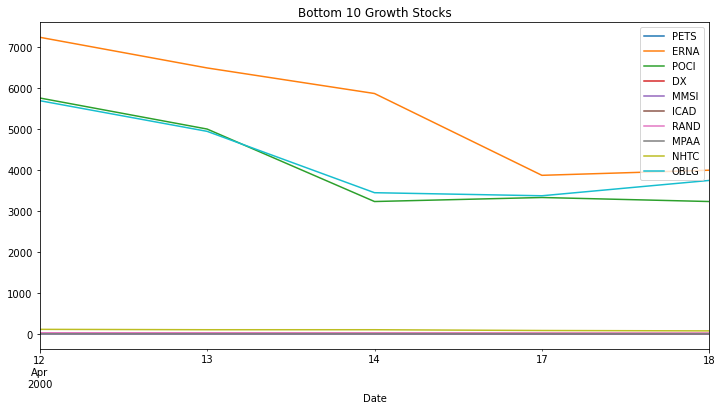

PETS - PetMed Express, Inc. - Common Stock

ERNA - Eterna Therapeutics Inc. - Common Stock

POCI - Precision Optics Corporation, Inc. - Common stock

DX - Dynex Capital, Inc. Common Stock

MMSI - Merit Medical Systems, Inc. - Common Stock

ICAD - icad inc. - Common Stock

RAND - Rand Capital Corporation - Closed End Fund

MPAA - Motorcar Parts of America, Inc. - Common Stock

NHTC - Natural Health Trends Corp. - Commn Stock

OBLG - Oblong Inc. - Common Stock



In [53]:
display_names(bottom_growth_stocks(df, '2000-04-12', '2000-04-18', 10))

Not a whole lot to be said about that.  Other than the dip in 2020, the stocks most affected by these swing days seem unrelated.

Overall, it looks like 2000-2001 were some turbulent years.  There are also some stock that are strangely high compared to what I know about the stock market.  Let's look a bit further into that, and find the most expensive stock on each of those dates.

## Most expensive stocks at each point of variance

### 1. 2001-01-03

In [54]:
display_name(most_expensive_stock(df, '2001-01-03'))

The most expensive stock on 2001-01-03 was NXPL at a price of $8859374592.00
NXPL - NextPlat Corp - Common Stock



Sorry, does that say NextPlat was worth almost 9 BILLION per stock in 2001???

A quick fact check shows that Berkshire Hathaway in the highest value single stock in history, at somewhere between $445,000 and $630,000 depending on the source.  Either way, that's nowhere near 9 billion, so what gives?

Frankly, I can't find an answer to that.  All the data I can find online confirms this historic closing price of almost 9 billion.  No other data supports this fact though, so at the end of the day it's probably a mistake in the data that's been passed down for years.  I don't know for sure though, so here it stays.

### 2. 2020-03-16

In [55]:
display_name(most_expensive_stock(df, '2020-03-16'))

The most expensive stock on 2020-03-16 was NRGD at a price of $1087600.00
NRGD - MicroSectors U.S. Big Oil Index -3X Inverse Leveraged ETN



This also looks weird, but technically this 'stock' represents a conglomerate of 10 other oil stocks.  So, less weird than NextPlat, this one checks out.

### 3. 2008-10-13

In [56]:
display_name(most_expensive_stock(df, '2008-10-13'))

The most expensive stock on 2008-10-13 was TOPS at a price of $37497602048000.00
TOPS - TOP Ships Inc. - Common Stock



Another huge number.  It seems like I've been lied to about Berkshire Hathaway...time to dig a little deeper.

There's something else I've been missing.  Historical data is often adjusted for stock splits, which consolidates or splits existing shares.  This snowball effect can skyrocket historical data to insane prices, like what we've been seeing.  It's just yet another way that this dataset really isn't suitable for anything I wanted to investigate.  I'm starting to think I was a bit more ambitious than I expected.

### 4. 2000-12-05

In [57]:
display_name(most_expensive_stock(df, '2000-12-05'))

The most expensive stock on 2000-12-05 was NXPL at a price of $12656249856.00
NXPL - NextPlat Corp - Common Stock



### 5. 2000-04-14

In [58]:
display_name(most_expensive_stock(df, '2000-04-14'))

The most expensive stock on 2000-04-14 was NXPL at a price of $50624999424.00
NXPL - NextPlat Corp - Common Stock



Once again, this data has proved less useful than expected.  I don't think there's much to be seen with these crazy inflated historical stocks, so we'll just move on.

## Individual Stock Analysis

There weren't as many reoccuring stocks throughout those swing days as I'd hoped, so lets analyze the stocks that were most affected the previous swing days.  This will be done with candlestick and line graph/volume visualizations for the months surrounding the drastic market average change.

### 1. CXW - CoreCivic inc.

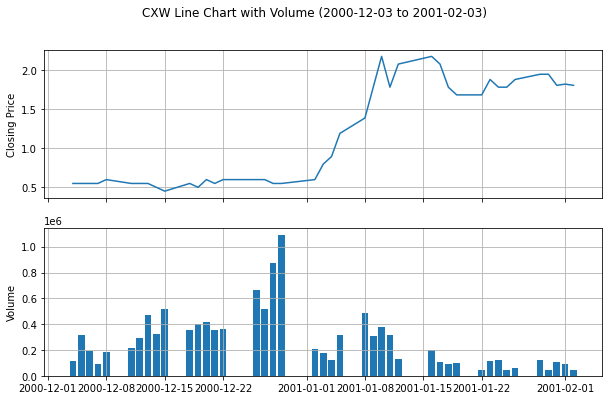

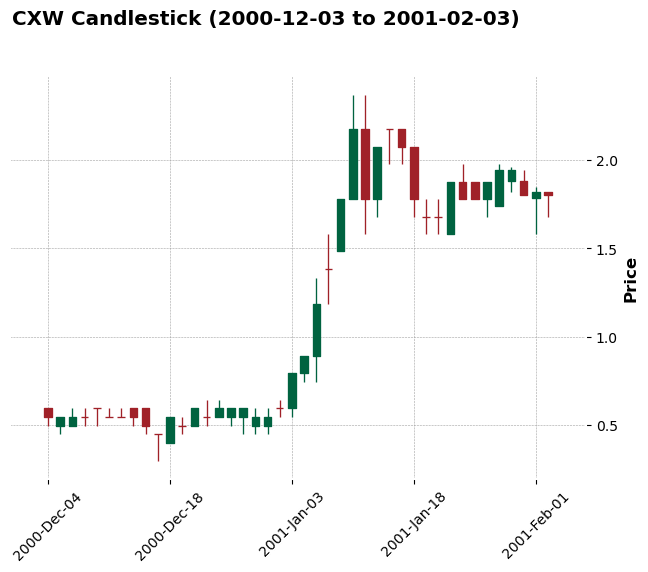

In [59]:
visualize_line_volume('CXW', '2000-12-03', '2001-02-03')
visualize_candlestick('CXW', '2000-12-03', '2001-02-03')

### 2. INLX - Intellinetics Inc

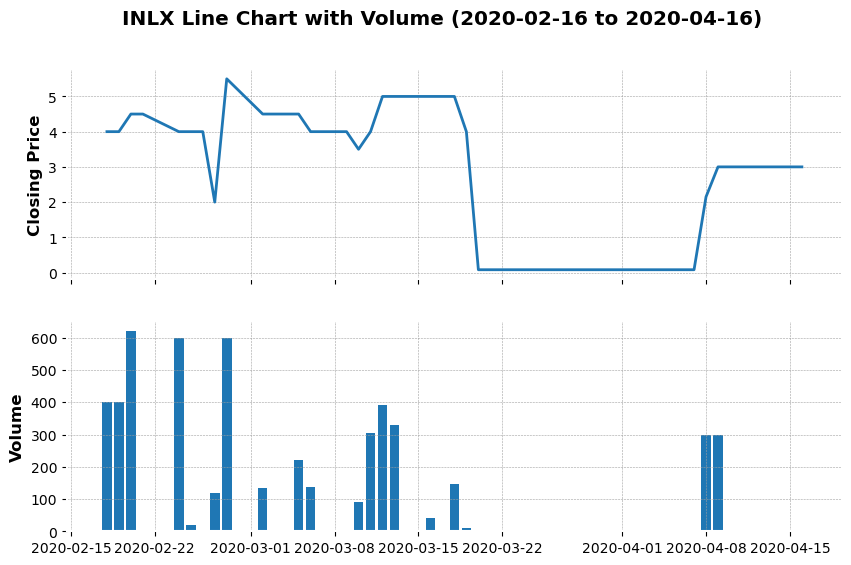

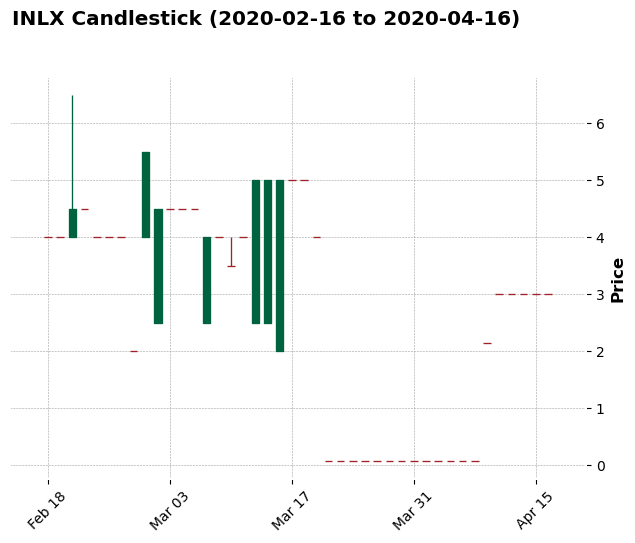

In [60]:
visualize_line_volume('INLX', '2020-02-16', '2020-04-16')
visualize_candlestick('INLX', '2020-02-16', '2020-04-16')

### 3. PALT - Paltalk inc.

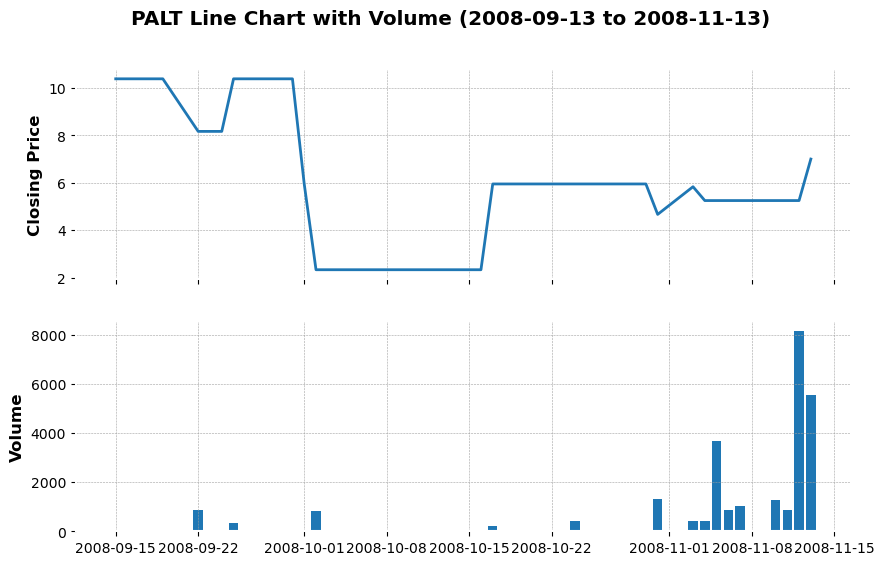

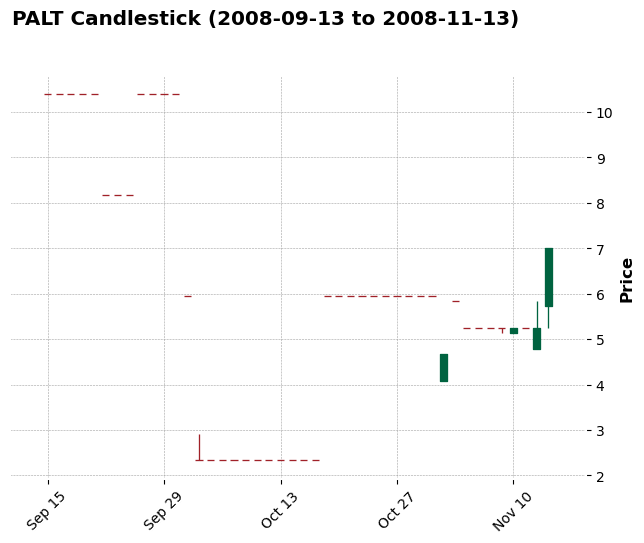

In [61]:
visualize_line_volume('PALT', '2008-09-13', '2008-11-13')
visualize_candlestick('PALT', '2008-09-13', '2008-11-13')

### 4. EGY - VAALCO Energy Inc.

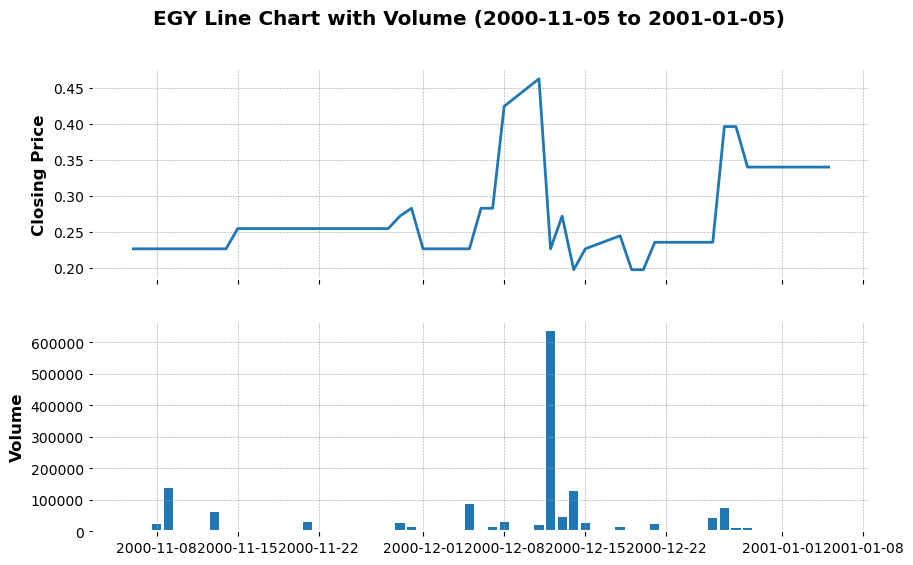

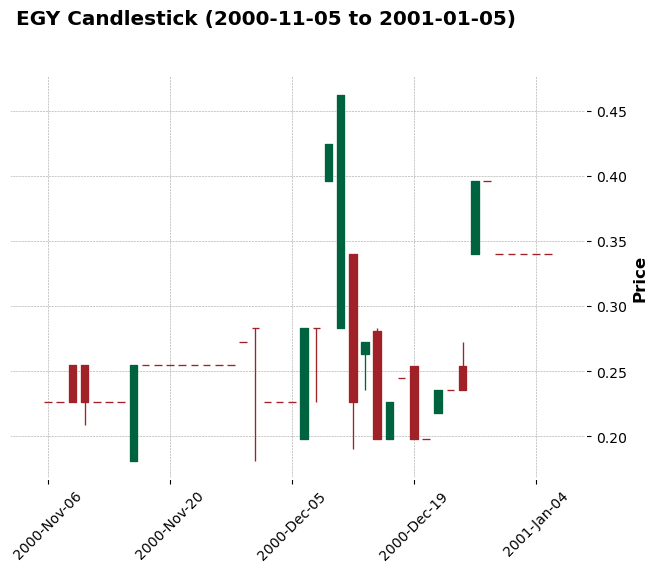

In [62]:
visualize_line_volume('EGY', '2000-11-05', '2001-01-05')
visualize_candlestick('EGY', '2000-11-05', '2001-01-05')

### 5. PETS - PetMed Express, Inc

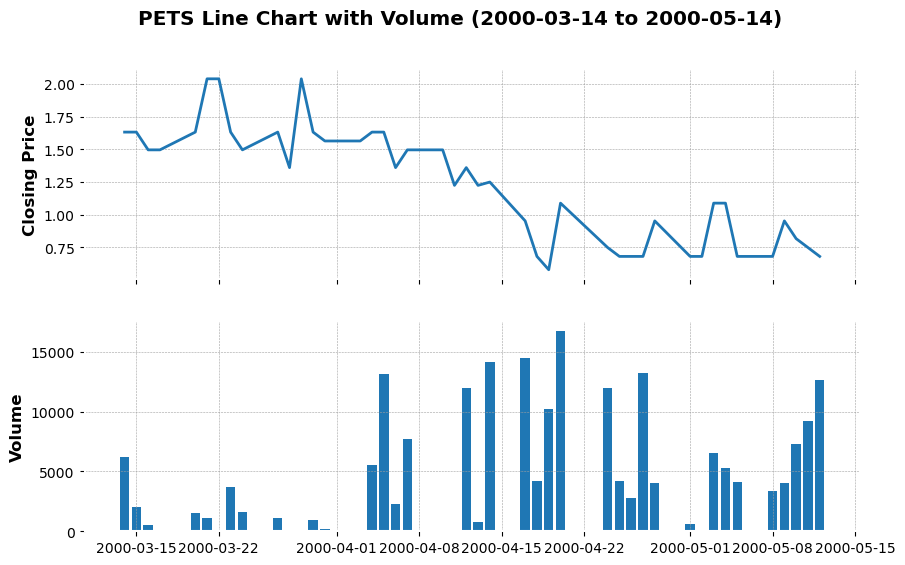

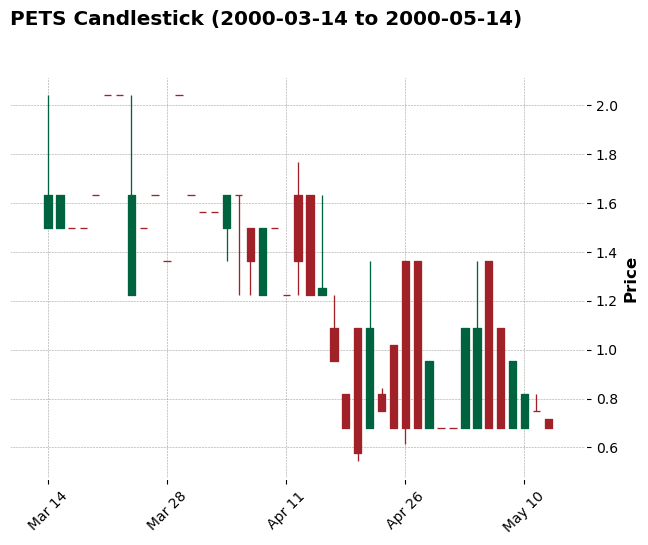

In [63]:
visualize_line_volume('PETS', '2000-03-14', '2000-05-14')
visualize_candlestick('PETS', '2000-03-14', '2000-05-14')

Great, but does that tell us anything?

Well, aside from the stock choice ending up pretty random and unrelated, it tells a few things about each stock.

Candlestick visuals are a unique visualization of choice for stock data.  Here's how they work (apparently).  The upper and lower 'wicks' are the high price and low price of the given day.  The top and bottom of the body are the open a close price.  If the body is green, the top of the 'candle' is the closing price, meaning the close on that day was higher than the open.  If red, it means the opposite: the price went down between the close and the open.  

Basically, taller candle = bigger range of values on that day.  Red candle, value went down.  Green candle, value went up.  They're a good way to visualize how fickle a stocks behaviour can be over any given day.  Here's a slightly more relevant example, just for fun.

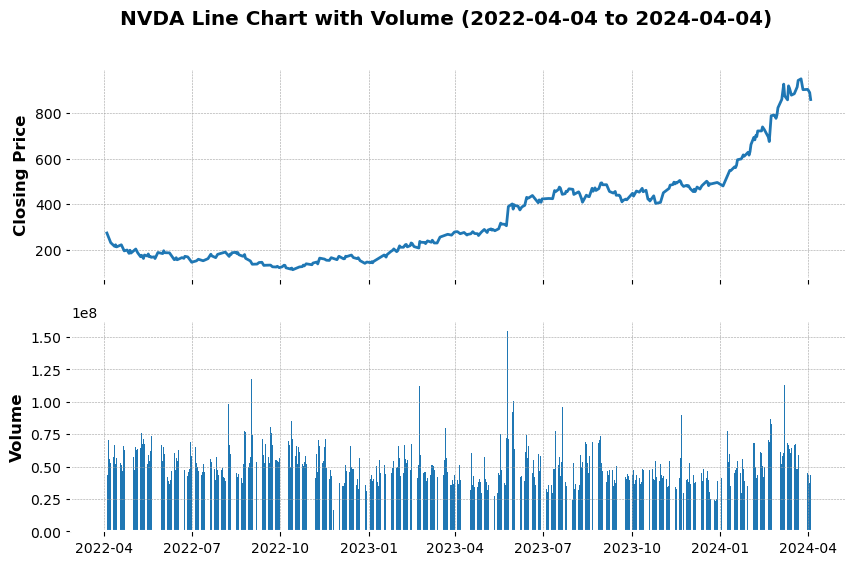

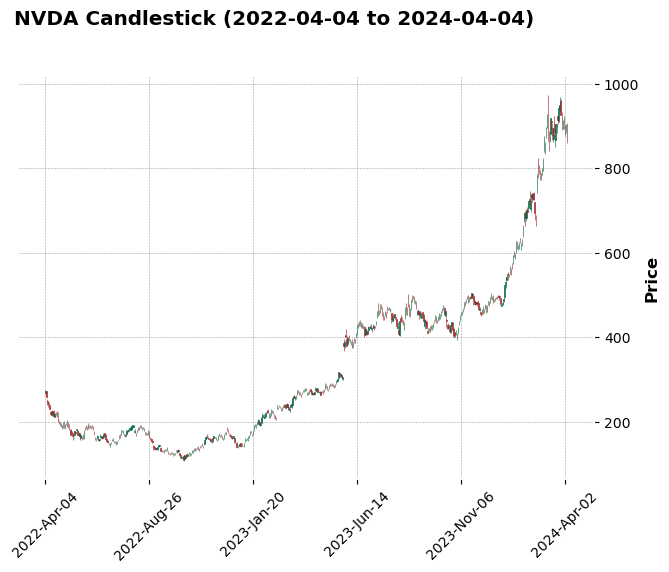

In [64]:
visualize_line_volume('NVDA', '2022-04-04', '2024-04-04')
visualize_candlestick('NVDA', '2022-04-04', '2024-04-04')

What the candlestick doesn't cover is trading volume, or the number of times that stock was traded on any given day, hence the other visualization.

## Summary (so far)

Frankly, this project has derailed a bit at several different points.  Perhaps it would've been wiser to pick a topic I knew more about, or form a larger team to divide the effort up further.  Here we are though, I hope I've done a decent job handling this overly frustrating data, and learned quite a bit about the stock market along the way.

As far as my hypothesis goes, I think it's safe to say that I was largely incorrect in my assumptions.  I thought that major dips in the market average would reliably coincide with major events.  However, that doesn't seem to be the case.  In both my flawed analysis of the market average, and more official record of the largest swing days in history, it's more often the case that if the market responds to any news, it's usually just news about the stock market itself.  The only case to the contrary I could find was the onset of the global pandemic, which was an outlier in a number of different ways.  Otherwise, the market largely remains inscrutable to me, and despite everything I've learned along the way, I still understand very little.  Certainly, the job of market analyst remains safe from CS undergrads like myself.

### Final Steps

#### Associate Rule Mining

Unfortunately, my main dataset is far too large to effictively rule mine.  As an alterantive/compromise, I've isolated the history of the 15 stocks with the highest current market cap (total value of all shares) to their own file, and we will perform associate rule mining on those stocks during the months surrounding days of highest variance.

This may not prove as useful as mining the entire dataset of stocks, but it will at least show us potentially valuable connections between major stocks during times of change.

We will investigate the top 15 highest confidence rules (which are often 1 over time periods of a few months), and the plot the value of each to visualize whether these stocks increase or decrease together.

For reference, these are the names of the top 15 stocks that will be rule mined:

In [65]:
display_names(top_tickers)

AAPL - Apple Inc. - Common Stock

AMZN - Amazon.com, Inc. - Common Stock

AVGO - Broadcom Inc. - Common Stock

No data for ticker: BRK/A
No data for ticker: BRK/B
GOOG - Alphabet Inc. - Class C Capital Stock

GOOGL - Alphabet Inc. - Class A Common Stock

JPM - JP Morgan Chase & Co. Common Stock

LLY - Eli Lilly and Company Common Stock

META - Meta Platforms, Inc. - Class A Common Stock

MSFT - Microsoft Corporation - Common Stock

NVDA - NVIDIA Corporation - Common Stock

NVO - Novo Nordisk A/S Common Stock

TSM - Taiwan Semiconductor Manufacturing Company Ltd.

V - Visa Inc.



BRK/A and BRK/B refer to Berkshire Hathaway.

### 1. 2001-01-03

In [66]:
preprocessed_data = preprocess_data(df_15, "2000-12-03", "2001-02-03")
rules = perform_rule_mining(preprocessed_data)

                       antecedents         consequents  confidence
562               (JPM, LLY, NVDA)               (NVO)         1.0
1388  (TSM, MSFT, AMZN, AAPL, NVO)               (LLY)         1.0
1431  (TSM, AMZN, AAPL, NVO, NVDA)               (LLY)         1.0
487               (LLY, MSFT, TSM)              (AMZN)         1.0
997         (NVO, AAPL, NVDA, TSM)              (MSFT)         1.0
184                    (LLY, NVDA)               (NVO)         1.0
1517        (NVDA, AAPL, LLY, TSM)         (NVO, MSFT)         1.0
1323       (LLY, MSFT, NVDA, AMZN)         (NVO, AAPL)         1.0
1653        (NVO, AAPL, TSM, AMZN)   (LLY, MSFT, NVDA)         1.0
994         (NVO, AAPL, MSFT, TSM)              (NVDA)         1.0
1652        (LLY, MSFT, TSM, NVDA)   (NVO, AAPL, AMZN)         1.0
1216         (JPM, LLY, MSFT, TSM)        (AAPL, AMZN)         1.0
1407        (LLY, NVO, MSFT, AAPL)         (TSM, AMZN)         1.0
1432  (TSM, AMZN, AAPL, LLY, NVDA)               (NVO)        

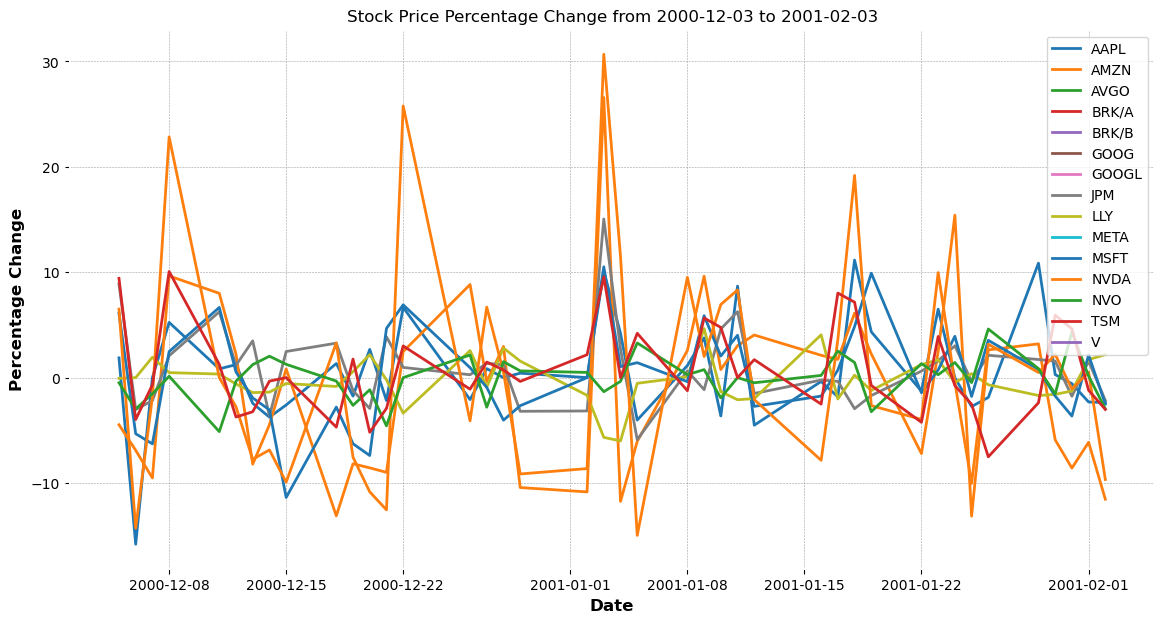

In [67]:
plot_stock_changes("2000-12-03", "2001-02-03", top_tickers)

The first thing to note is that some of the current biggest stocks were not always as important as they are now.  The lowest movement seen in this graph of early 2001 is Eli Lilly and Novo Nordisc, both of which are pharmaceutical companies that have seen meteoric rises in the past few years.  

It's also interesting that so many stocks can be directly tied to the movement of others.  This could be in part due to the way the stock market moves as a collective, but is also pretty consistent for these top stocks.

### 2. 2020-03-16

In [68]:
preprocessed_data = preprocess_data(df_15, "2020-02-16", "2020-04-16")
rules = perform_rule_mining(preprocessed_data)

                                   antecedents  \
991032   (GOOG, TSM, V, MSFT, AMZN, META, LLY)   
1054942                 (JPM, LLY, META, MSFT)   
669522    (GOOG, MSFT, META, GOOGL, NVO, NVDA)   
1054948                  (JPM, LLY, NVO, MSFT)   
204550                  (LLY, NVO, MSFT, AAPL)   
669521     (GOOG, MSFT, META, AVGO, NVO, NVDA)   
1054953                (JPM, META, LLY, GOOGL)   
204547                 (LLY, NVO, MSFT, GOOGL)   
1054954                  (JPM, NVO, META, LLY)   
363797       (GOOG, TSM, V, MSFT, META, GOOGL)   
1054957                  (JPM, NVO, LLY, AVGO)   
363798        (GOOG, TSM, V, MSFT, META, NVDA)   
1054958                 (JPM, NVO, LLY, GOOGL)   
204541                  (LLY, NVO, MSFT, AMZN)   
1055056                        (JPM, NVO, LLY)   

                               consequents  confidence  
991032                        (AVGO, NVDA)         1.0  
1054942         (TSM, V, AVGO, GOOGL, NVO)         1.0  
669522                      

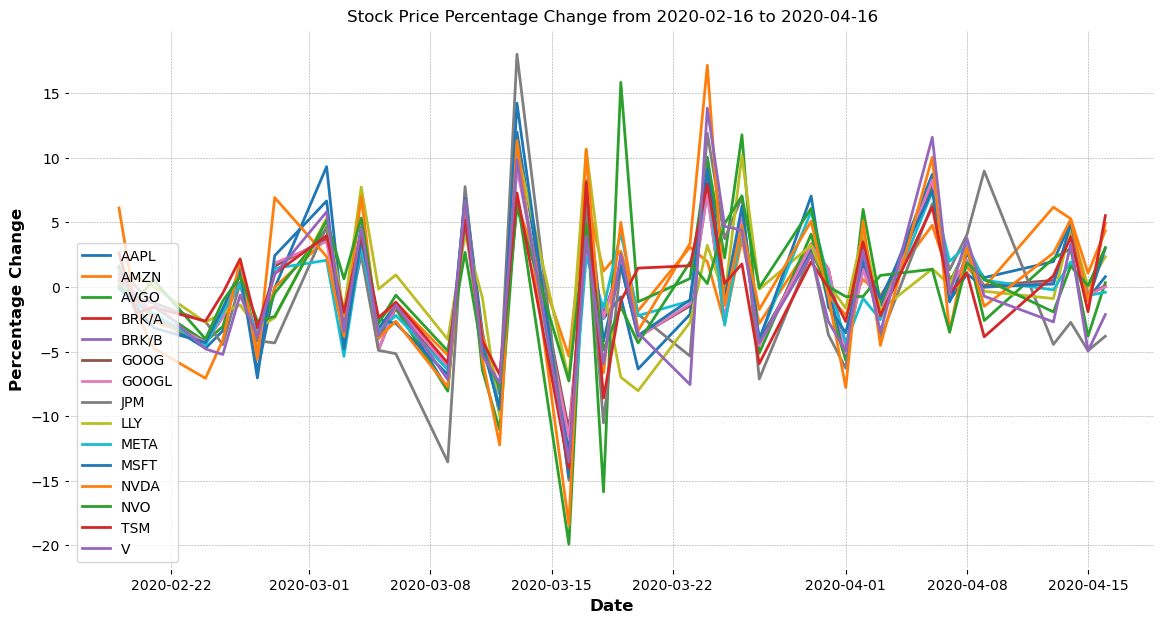

In [69]:
plot_stock_changes("2020-02-16", "2020-04-16", top_tickers)

There's a very distinct pattern on this day, where all of the more modern top stocks move together on most days.  The turbulent nature of the current events clearly led to huge swings over a few days, as people would panic sell stocks one day, and buy the dip the next.  This image will likely be the clearest pattern visible in any of these rule mining visuals.

### 3. 2008-10-13

In [70]:
preprocessed_data = preprocess_data(df_15, "2008-09-13", "2008-11-13")
rules = perform_rule_mining(preprocessed_data)

                                            antecedents    consequents  \
28277                     (JPM, MSFT, AAPL, GOOGL, LLY)         (NVDA)   
115971  (GOOG, MSFT, AMZN, AAPL, GOOGL, NVO, LLY, NVDA)          (JPM)   
19726                       (GOOG, V, AMZN, AAPL, NVDA)          (LLY)   
19725                        (GOOG, V, AMZN, AAPL, LLY)         (NVDA)   
115964  (JPM, GOOG, MSFT, AMZN, GOOGL, AAPL, NVO, NVDA)          (LLY)   
115966   (JPM, GOOG, MSFT, AMZN, GOOGL, NVO, LLY, NVDA)         (AAPL)   
115967    (JPM, GOOG, MSFT, AMZN, AAPL, NVO, LLY, NVDA)        (GOOGL)   
115968   (JPM, GOOG, MSFT, AAPL, GOOGL, NVO, LLY, NVDA)         (AMZN)   
115970   (JPM, MSFT, AMZN, AAPL, GOOGL, NVO, LLY, NVDA)         (GOOG)   
115972        (JPM, GOOG, MSFT, AMZN, GOOGL, AAPL, NVO)    (LLY, NVDA)   
46275                 (GOOG, TSM, V, AMZN, GOOGL, NVDA)         (AAPL)   
115975         (JPM, GOOG, MSFT, AMZN, GOOGL, NVO, LLY)   (NVDA, AAPL)   
115976        (JPM, GOOG, MSFT, AMZN, 

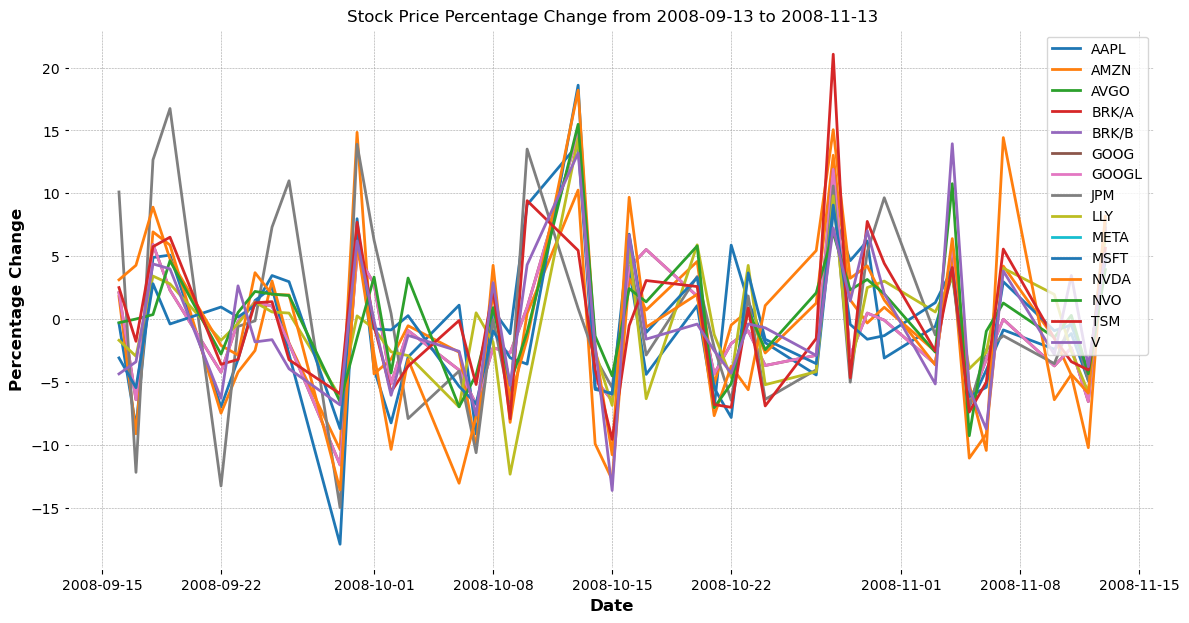

In [71]:
plot_stock_changes("2008-09-13", "2008-11-13", top_tickers)

This is pretty similar to the last visual.  I'm surprised by how much percentage variance even these key stocks can fluctuate over a matter of days.  Even days that didn't mark historic highs in market variance, these major stocks can fluctuate up to 20%.  It seems like a sign that these days of major market change are preceded and followed by weeks of buildup and cooldown, where the market is extremely volatile.

### 4. 2000-12-05

In [72]:
preprocessed_data = preprocess_data(df_15, "2000-11-05", "2001-01-05")
rules = perform_rule_mining(preprocessed_data)

                 antecedents        consequents  confidence
576  (NVDA, AAPL, MSFT, TSM)              (JPM)         1.0
123              (LLY, NVDA)              (JPM)         1.0
325         (LLY, TSM, AMZN)              (JPM)         1.0
645         (NVDA, LLY, TSM)        (JPM, AMZN)         1.0
313              (LLY, NVDA)        (JPM, AMZN)         1.0
711        (LLY, AAPL, AMZN)   (JPM, MSFT, TSM)         1.0
710        (LLY, MSFT, AAPL)   (JPM, TSM, AMZN)         1.0
311        (LLY, NVDA, AMZN)              (JPM)         1.0
308         (JPM, LLY, NVDA)             (AMZN)         1.0
652  (JPM, MSFT, NVDA, AMZN)              (TSM)         1.0
708         (AAPL, LLY, TSM)  (JPM, MSFT, AMZN)         1.0
611   (LLY, MSFT, TSM, AMZN)              (JPM)         1.0
653  (NVDA, MSFT, TSM, AMZN)              (JPM)         1.0
304        (LLY, MSFT, AMZN)              (JPM)         1.0
298        (AAPL, NVO, NVDA)              (TSM)         1.0


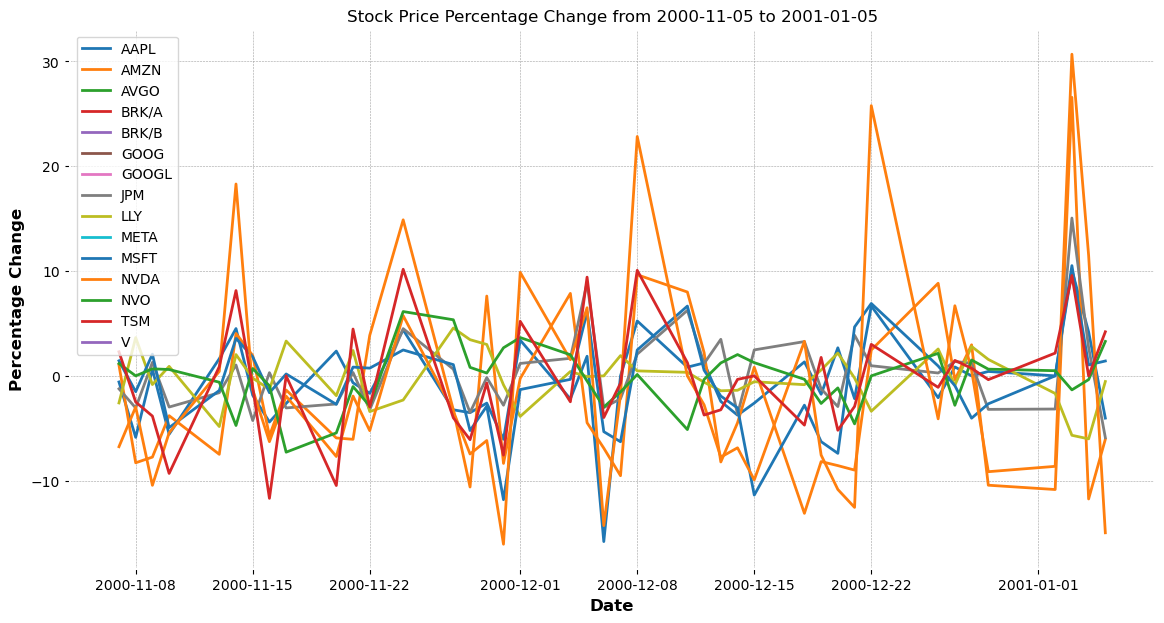

In [73]:
plot_stock_changes("2000-11-05", "2001-01-05", top_tickers)

This is similar to the first visualization, which is expected given the time overlap.  The difference in rule mining priority is iteresting though.  It's interesting that JP Morgan & Chase is so often the consquent of groups of other stocks though.

### 5. 2000-04-14

In [74]:
preprocessed_data = preprocess_data(df_15, "2000-03-14", "2000-04-14")
rules = perform_rule_mining(preprocessed_data)

                 antecedents   consequents  confidence
633          (JPM, NVO, LLY)  (AAPL, AMZN)         1.0
651   (AAPL, LLY, TSM, AMZN)         (JPM)         1.0
656         (JPM, LLY, AMZN)   (AAPL, TSM)         1.0
659         (LLY, TSM, AMZN)   (JPM, AAPL)         1.0
661        (LLY, AAPL, AMZN)    (JPM, TSM)         1.0
670  (JPM, MSFT, AAPL, AMZN)         (NVO)         1.0
671   (JPM, NVO, MSFT, AMZN)        (AAPL)         1.0
672   (JPM, NVO, MSFT, AAPL)        (AMZN)         1.0
674  (NVO, MSFT, AAPL, AMZN)         (JPM)         1.0
675        (JPM, MSFT, AMZN)   (NVO, AAPL)         1.0
677         (JPM, NVO, MSFT)  (AAPL, AMZN)         1.0
682        (NVO, MSFT, AMZN)   (JPM, AAPL)         1.0
688   (JPM, MSFT, TSM, AMZN)        (AAPL)         1.0
691  (JPM, MSFT, AAPL, AMZN)         (TSM)         1.0
692  (AAPL, MSFT, TSM, AMZN)         (JPM)         1.0


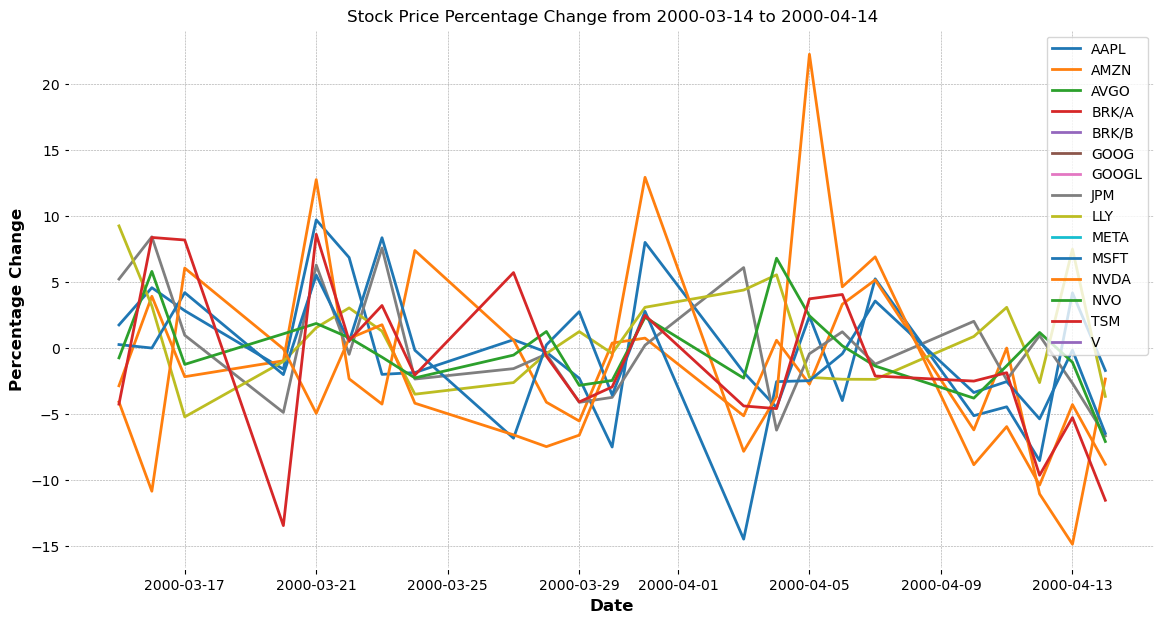

In [75]:
plot_stock_changes("2000-03-14", "2000-04-14", top_tickers)

This is the most chaotic yet, and therefore maybe the most useful in terms of rules mining.  Unfortunately, the time has long past that the rules mined here could be used to predict future stock movement. However, it at least reveals some useful patterns, like the connection between tech stocks and banking stocks, and how tech stocks have always somewhat risen and fallen together.

## Final Summary

Given how few stocks I can actually run the rule mining on, this is still relatively interesting.  I think this data shows that recently (using the 2020 data as the most crucial given its recency) major stocks are increasingly connected in most cases.  Therefore, studying and predicting the trends of one stock can conceivably be translated to the movement of other major stocks.  Especially during time of turbulence in the market, if you can predict the movemeent of Apple, assume that the other tech stocks will follow either up or down.  If you are trading live, and Google is going up, buy Amazon as well.  This still isn't as useful as prediction, as this knowledge relies on knowing the current direction of movement, but seems more reliable than prediction at least.